# Data Preprocessing: Images

This notebook focuses on the images preprocessing steps for the model development.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import os
import pandas as pd
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

2023-11-15 22:37:31.612604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Quick Image-Label Validation

For better organization, we make sure our naive labels match the images.

In [ ]:
from src.data.preprocessing import validate_images_and_labels

directory = 'data/external/source-ik/'
masterlist = pd.read_csv('data/external/source-ik/masterlist.csv')

validate_images_and_labels(directory, masterlist)

## Pose Landmark Extraction from Images

In the following section, we automate the extraction of pose landmarks. For each pose, we obtain normalized x, y, and z coordinates along with visibility information for the 33 landmarks identified by Mediapipe's model. Definitions of each value can be found [here](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python#handle_and_display_results).

![Mediapipe Landmark Reference](notebooks/images/mediapipe_references.png)

### Individual Extraction

In [2]:
from src.data.pose_estimation import extract_static_pose, download_landmarks_csv, download_landmarks_png

sample_input_path = 'data/external/source-ik/0-stand.png'
sample_output_path = 'data/interim/source-ik/0-stand.png'
sample_output_dir = 'data/interim/source-ik/'

landmarks, annotated_image = extract_static_pose(sample_input_path,0.5,0.5,2)
download_landmarks_csv(landmarks, sample_input_path, sample_output_dir)
download_landmarks_png(annotated_image, sample_output_path, sample_output_dir)

sample = pd.read_csv('data/interim/source-ik/0-stand.csv')
sample.describe()

I0000 00:00:1700084255.711618       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.27), renderer: Intel(R) Iris(TM) Plus Graphics 655
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


,x,y,z,v
count,33.000000,33.000000,33.000000,33.000000
mean,0.542956,0.368048,-0.354421,0.989537
std,0.188434,0.221109,0.289187,0.026357
min,0.154641,0.189213,-0.668354,0.863744
25%,0.512757,0.201884,-0.593714,0.996622
50%,0.544535,0.265693,-0.454328,0.998815
75%,0.607998,0.443059,-0.194515,0.999991
max,0.894314,0.830505,0.314865,0.999997


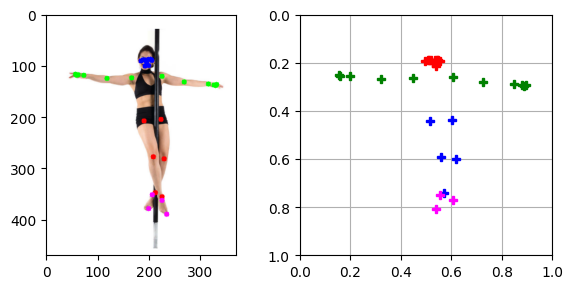

In [3]:
sample_annotated = cv2.imread('data/interim/source-ik/0-stand.png')
x = sample.iloc[:, 0].to_numpy()
y = sample.iloc[:, 1].to_numpy()

fig, axes = plt.subplots(1,2, figsize=(6, 3))
axes[0].imshow(sample_annotated)
axes[1].plot(x[0:10], y[0:10], color=mcolors.CSS4_COLORS['red'], label="head", marker='P', linestyle='None')
axes[1].plot(x[11:22], y[11:22], color=mcolors.CSS4_COLORS['green'], label="mid body", marker='P', linestyle='None')
axes[1].plot(x[23:28], y[23:28], color=mcolors.CSS4_COLORS['blue'], label="lower body", marker='P', linestyle='None')
axes[1].plot(x[29:32], y[29:32], color=mcolors.CSS4_COLORS['magenta'], label="feet", marker='P', linestyle='None')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].invert_yaxis()
axes[1].grid()
fig.tight_layout()
plt.show()

### Batch Extraction

In [31]:
def batch_process_png_files(input_dir, output_dir):
    count = 0
    error = 0
    for filename in os.listdir(input_dir):
        if filename.endswith(".png"):
            image_url_path = os.path.join(input_dir, filename)
        if os.path.exists(image_url_path):
            landmarks, annotated_image = extract_static_pose(image_url_path, 0.5, 0.5, 2)
            download_landmarks_csv(landmarks, image_url_path, output_dir)
            download_landmarks_png(annotated_image, image_url_path, output_dir)
            count += 1
        else:
            print(f"{image_url_path} cannot be found.")
            error += 1
        
    print(f"{count} images processed, {error} images skipped")

In [ ]:
input_dir = "data/external/source-ik/"
output_dir = "data/processed/source-ik-2/"

batch_process_png_files(input_dir, output_dir)

### Plotting Pose Examples

We will choose samples that may represent the training data gathered:
1. Lateral Pose
2. Horizontal Pose
3. Upright Pose
4. Inverted Pose
5. Back Grip Pose (Cropped)
6. Front Grip Pose (Cropped)

We conducted two runs of pose landmark extraction for quality assessment and comparison.
1. `processed/source-ik` refers to first batch
2. `processed/source-ik-2` refers to second batch

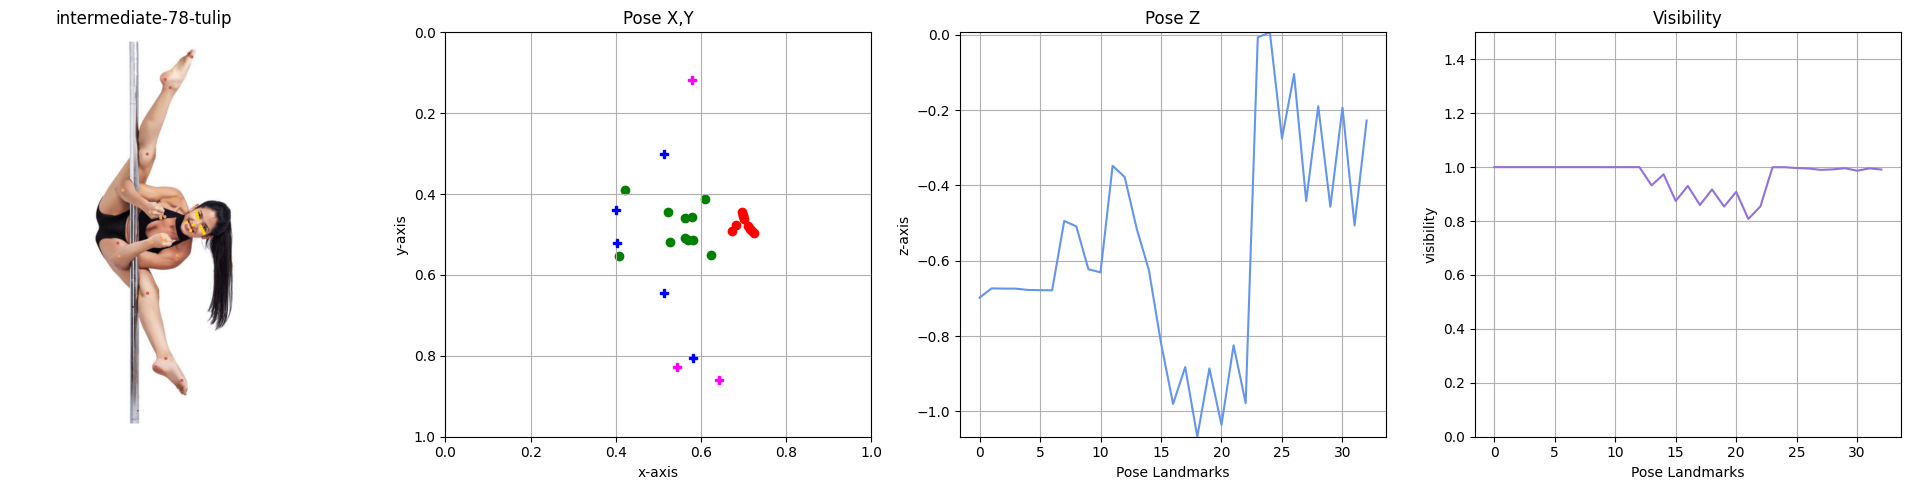

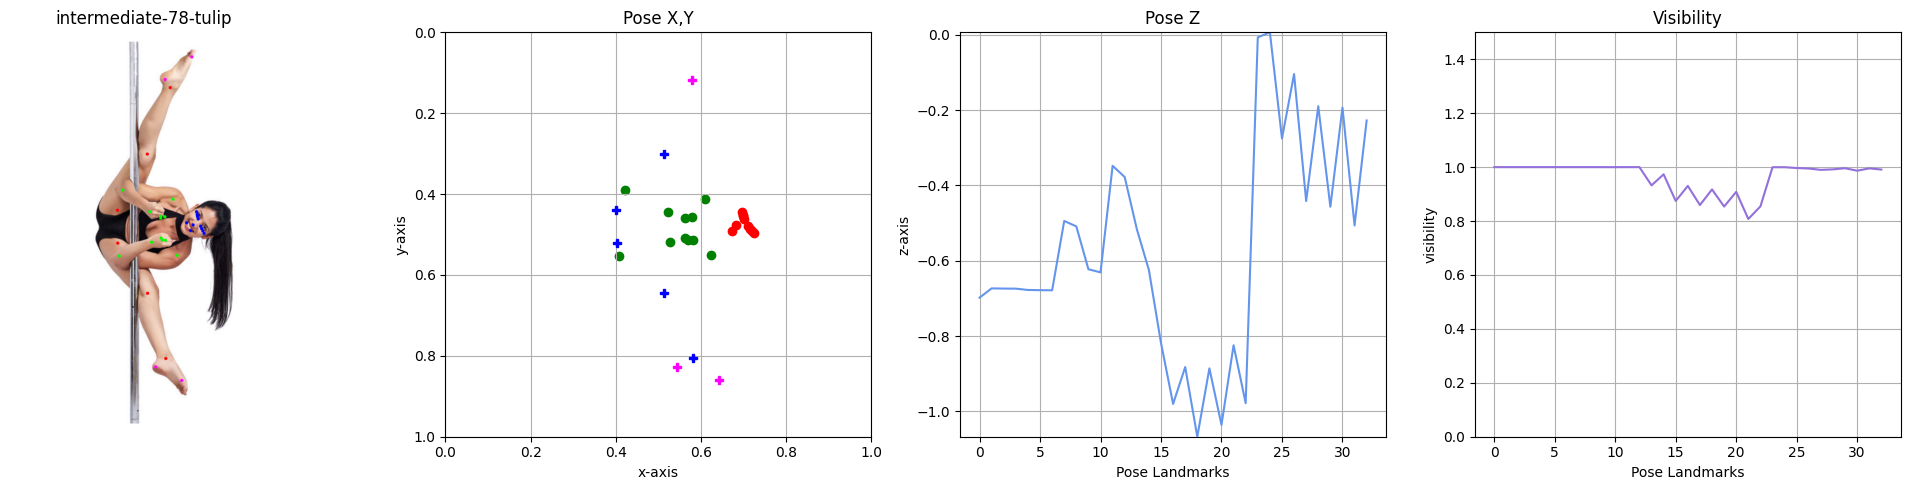

In [20]:
from src.data.plot_landmarks import plot_pose_xyzv_values

plot_pose_xyzv_values(
    'data/processed/source-ik/intermediate-78-tulip.csv',
    'data/processed/source-ik/intermediate-78-tulip.png')
plot_pose_xyzv_values(
    'data/processed/source-ik-2/intermediate-78-tulip.csv',
    'data/processed/source-ik-2/intermediate-78-tulip.png')

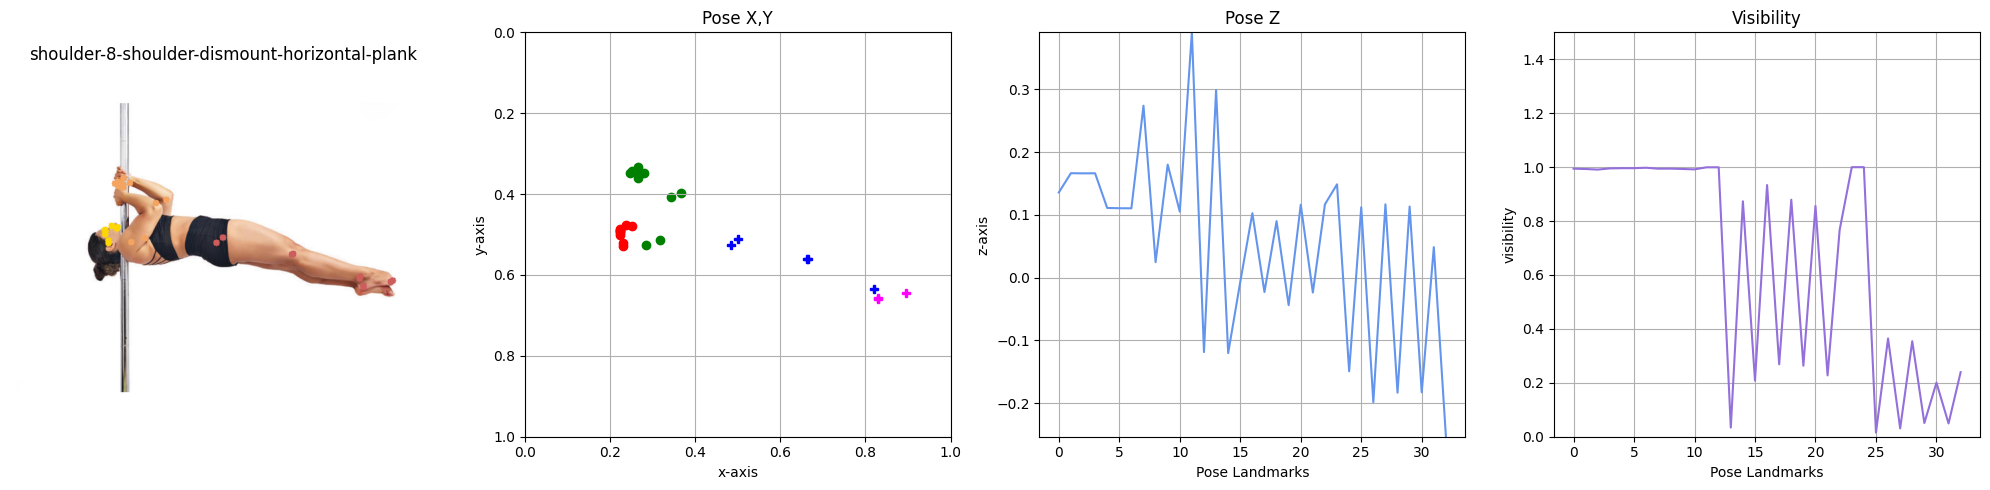

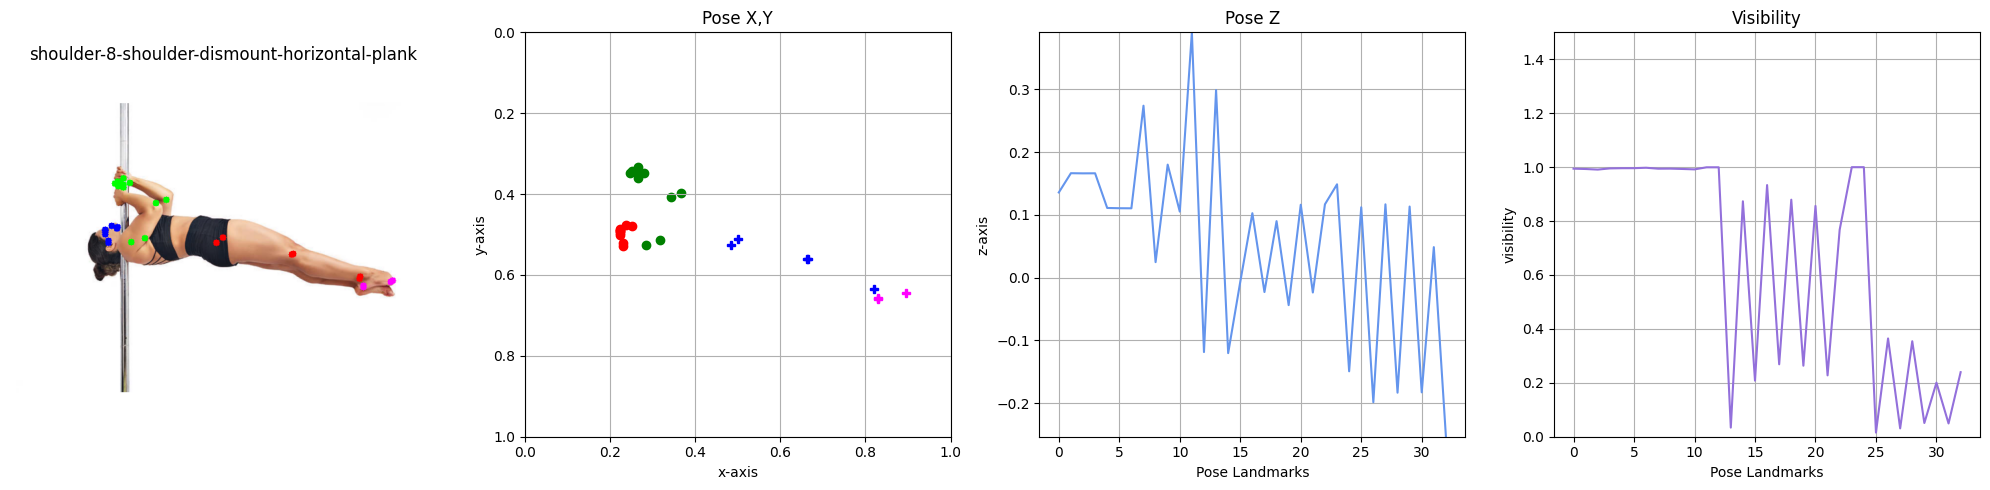

In [21]:
plot_pose_xyzv_values(
    'data/processed/source-ik/shoulder-8-shoulder-dismount-horizontal-plank.csv',
    'data/processed/source-ik/shoulder-8-shoulder-dismount-horizontal-plank.png')

plot_pose_xyzv_values(
    'data/processed/source-ik-2/shoulder-8-shoulder-dismount-horizontal-plank.csv',
    'data/processed/source-ik-2/shoulder-8-shoulder-dismount-horizontal-plank.png')

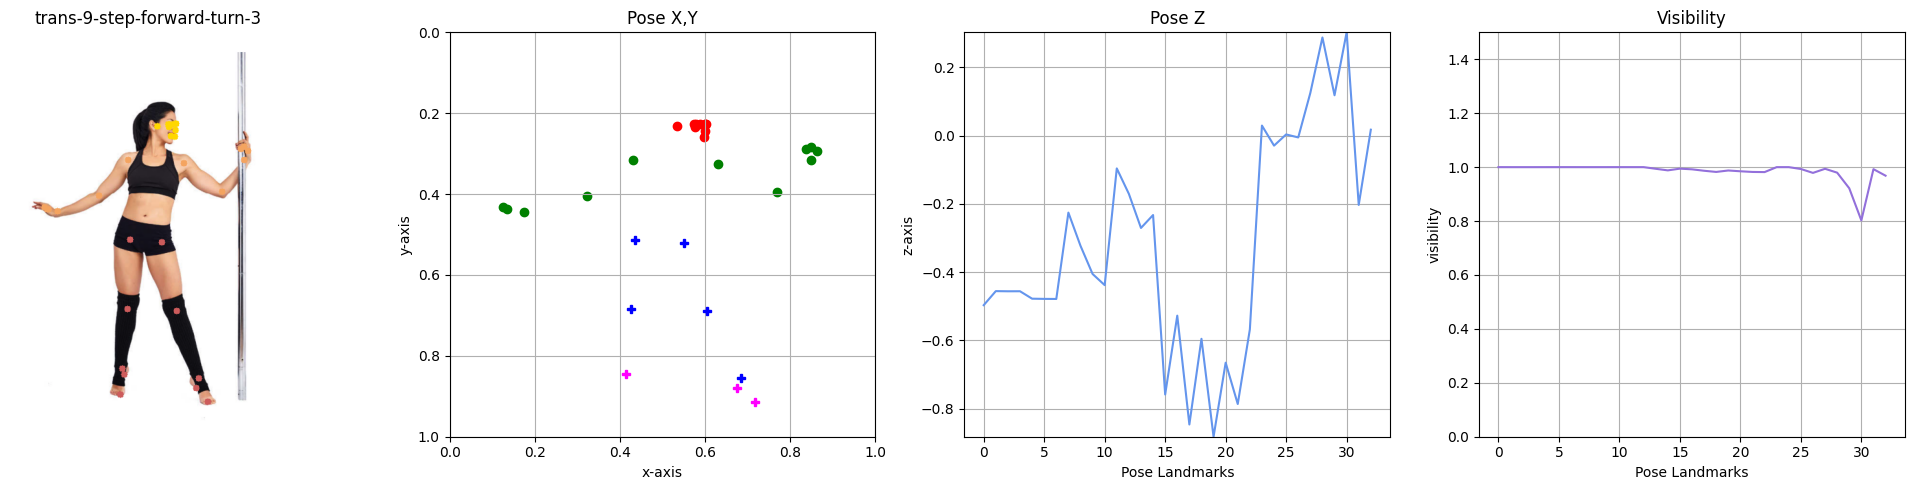

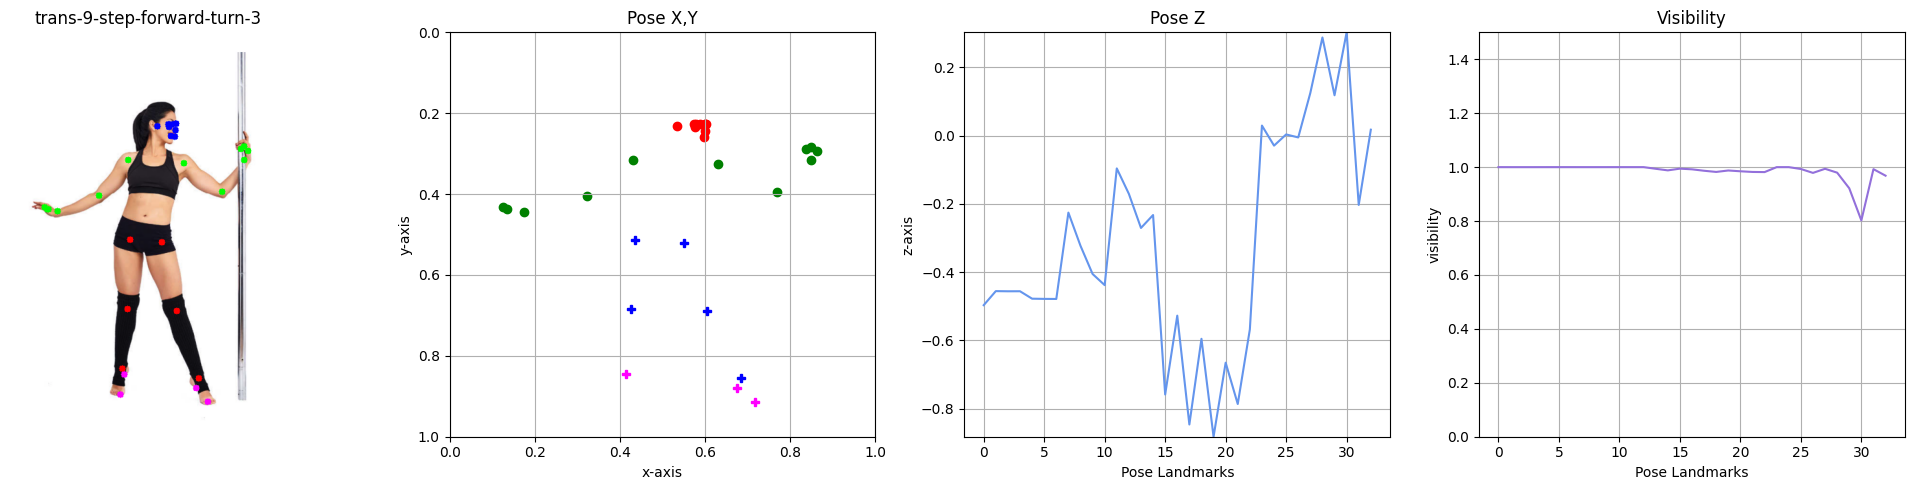

In [19]:
plot_pose_xyzv_values(
    'data/processed/source-ik/trans-9-step-forward-turn-3.csv',
    'data/processed/source-ik/trans-9-step-forward-turn-3.png')

plot_pose_xyzv_values(
    'data/processed/source-ik-2/trans-9-step-forward-turn-3.csv',
    'data/processed/source-ik-2/trans-9-step-forward-turn-3.png')

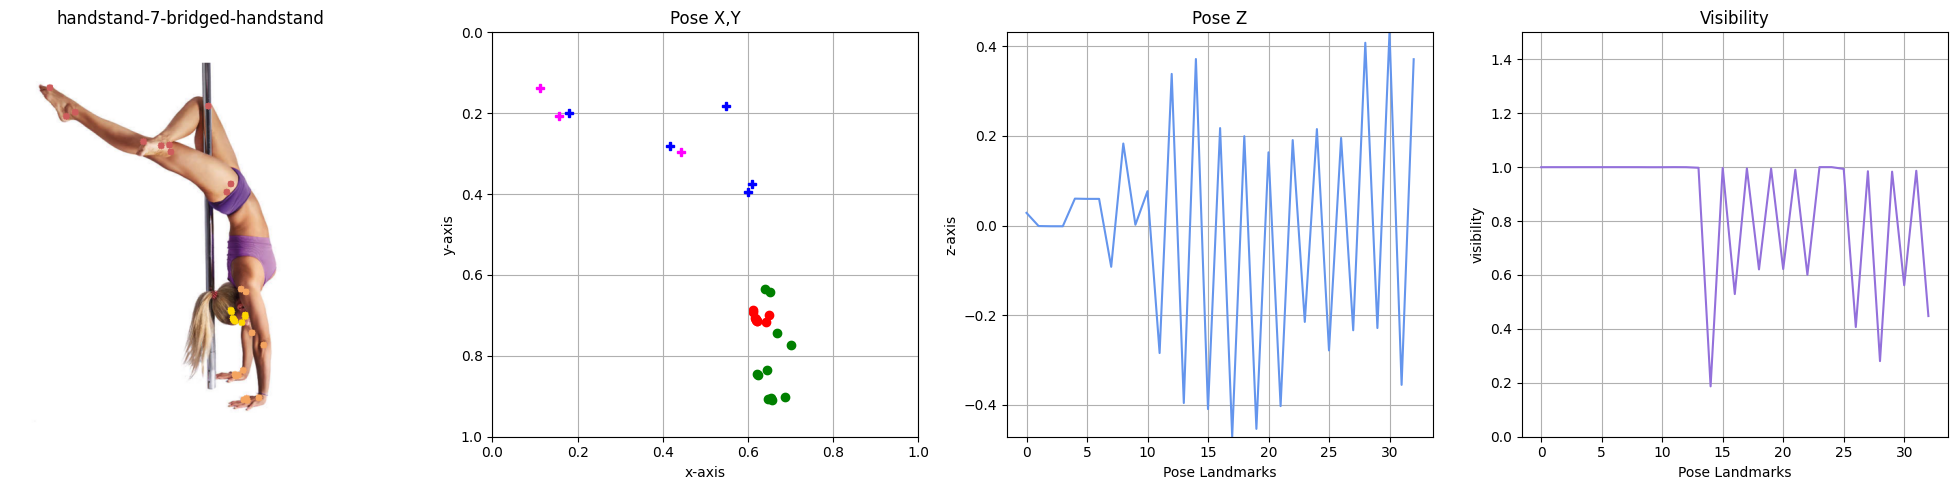

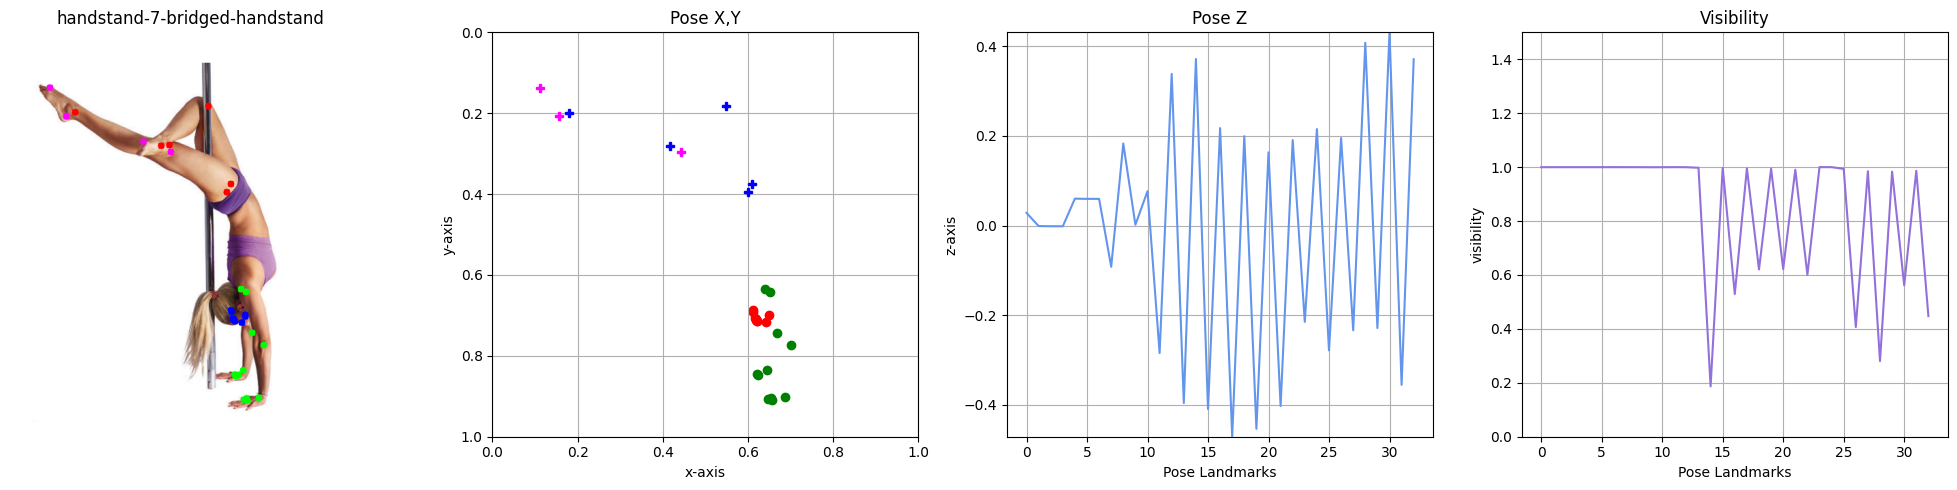

In [36]:
plot_pose_xyzv_values(
    'data/processed/source-ik/handstand-7-bridged-handstand.csv',
    'data/processed/source-ik/handstand-7-bridged-handstand.png')
plot_pose_xyzv_values(
    'data/processed/source-ik-2/handstand-7-bridged-handstand.csv',
    'data/processed/source-ik-2/handstand-7-bridged-handstand.png')

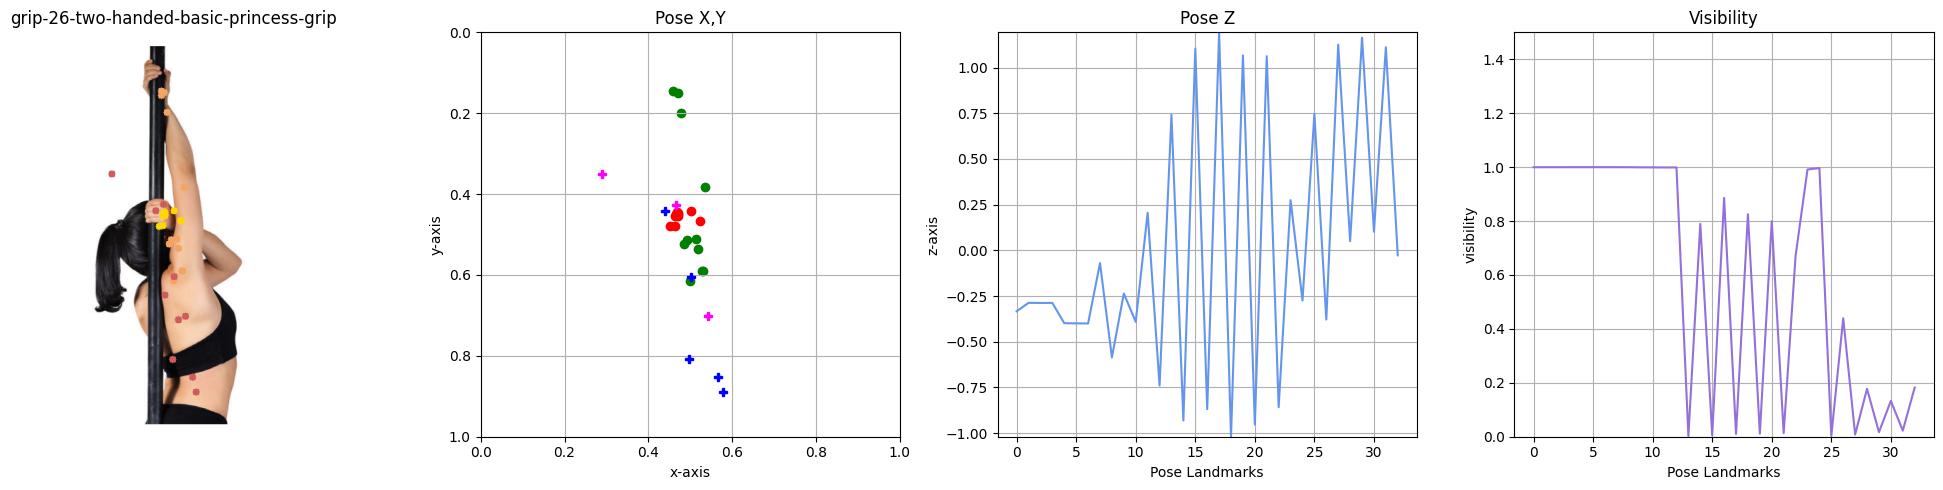

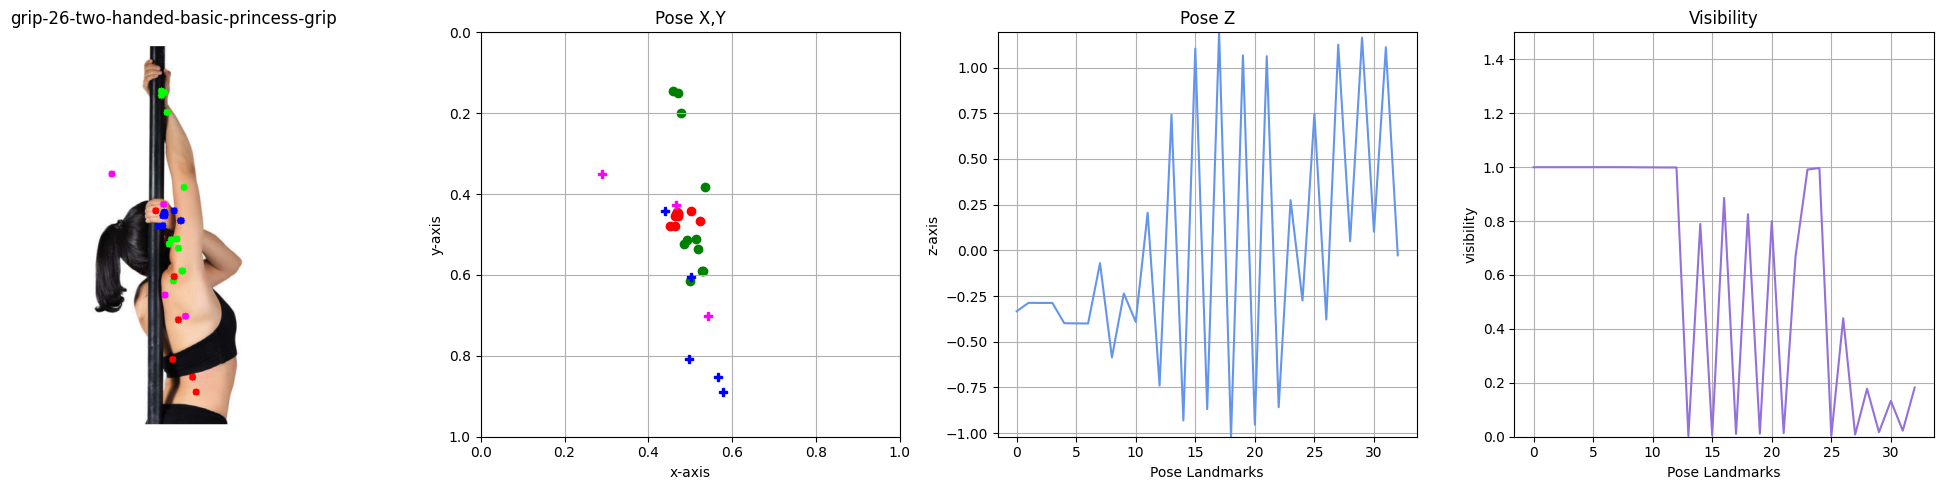

In [35]:
plot_pose_xyzv_values(
    'data/processed/source-ik/grip-26-two-handed-basic-princess-grip.csv',
    'data/processed/source-ik/grip-26-two-handed-basic-princess-grip.png')

plot_pose_xyzv_values(
    'data/processed/source-ik-2/grip-26-two-handed-basic-princess-grip.csv',
    'data/processed/source-ik-2/grip-26-two-handed-basic-princess-grip.png')

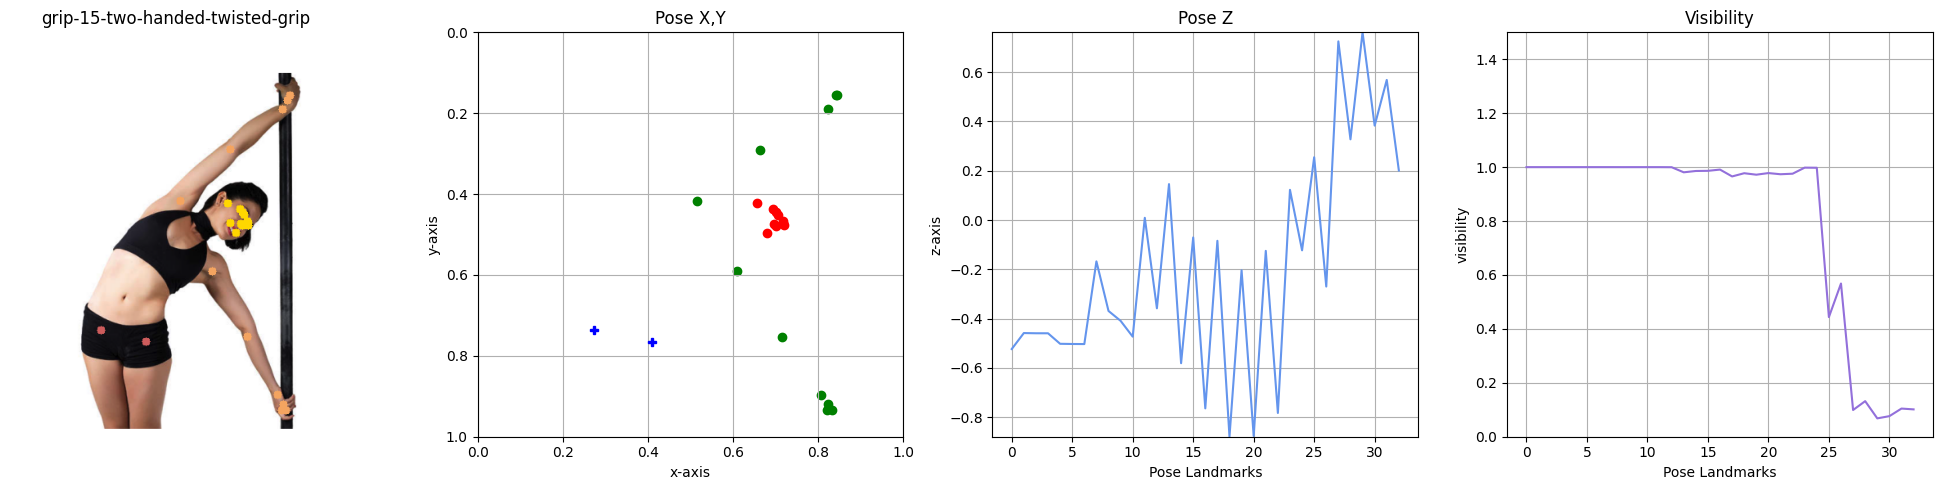

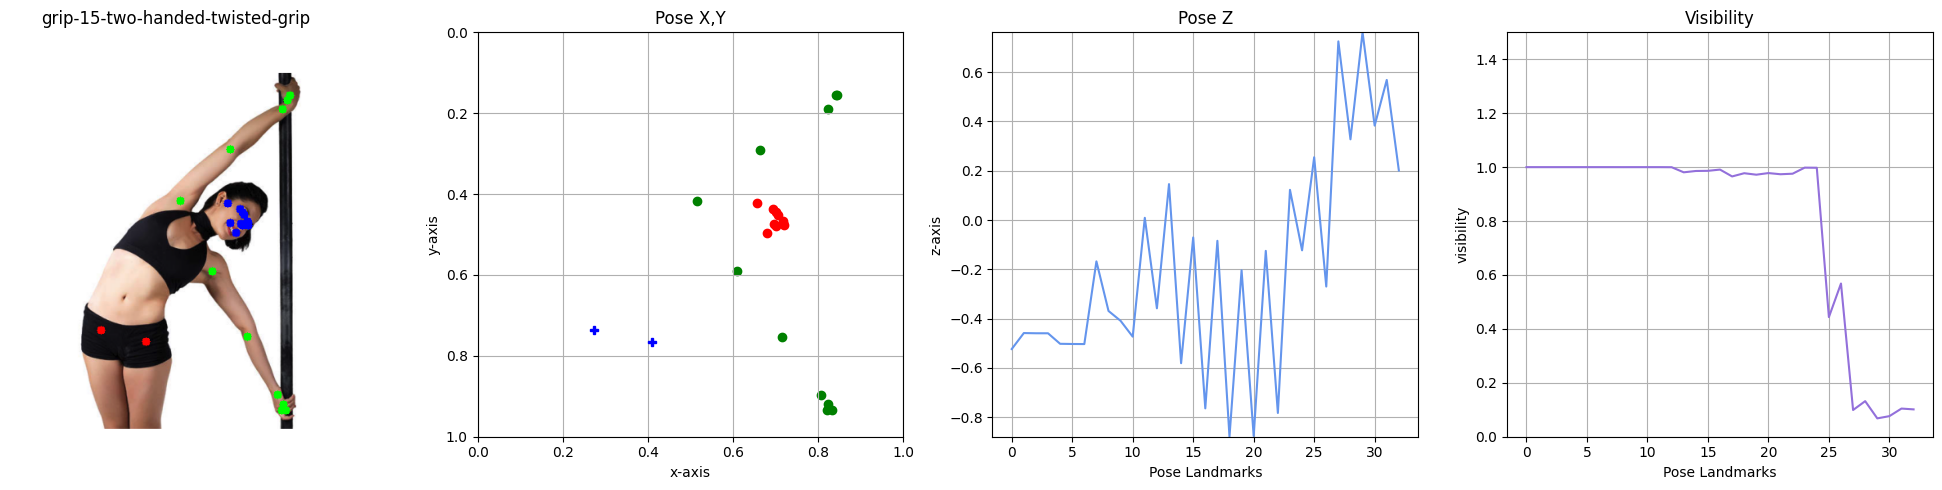

In [33]:
plot_pose_xyzv_values(
    'data/processed/source-ik/grip-15-two-handed-twisted-grip.csv',
    'data/processed/source-ik/grip-15-two-handed-twisted-grip.png')

plot_pose_xyzv_values(
    'data/processed/source-ik-2/grip-15-two-handed-twisted-grip.csv',
    'data/processed/source-ik-2/grip-15-two-handed-twisted-grip.png')

To interpret the pose estimation values more straightforwardly:

|Variable	|-0.0	|0.5	|+1.0|
|:-:|:-:|:-:|:-:|
x|Leftmost edge|Center|Rightmost edge
y|Topmost edge|Center|Bottommost edge
z|Closest to camera|Midway depth|Farthest from camera +
v|Predicted|Partially visible|Fully visible

 
**Key Observations:**

1. The x and y coordinates derived from the landmarks in our training dataset are generally reliable for pose estimation. Although some landmarks exhibit errors, the overall precision is deemed satisfactory for the scope of this project.
2. Visibility scores below 0.5 typically correspond to landmarks that the model cannot confidently detect, suggesting these can be disregarded for reliable pose information.
3. Asymmetrical poses are indicated by a fluctuating visibility pattern: a value of 0 represents the head at the center; (most) even-numbered landmarks align with the right side, and (most) odd-numbered landmarks with the left side of the body.
4. The z coordinates for poses directly facing the camera display inconsistent patterns, indicating potential measurement noise.
5. Even for truncated poses, visibility scores remain above zero, hinting that the model makes predictions for landmarks not entirely captured within the image frame.
6. Two separate extractions of pose data yielded consistent results, reinforcing the reliability of the process.
7. Distinction between front and back orientations using solely z and visibility metrics is not feasible. Incorporating additional features, such as categorical labels, could enhance pose differentiation.

## References

* https://github.com/google/mediapipe
* https://www.goodreads.com/book/show/43151907-pole-dance-fitness